In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from solver import *
import tensorflow as tf 
from tensorflow import keras

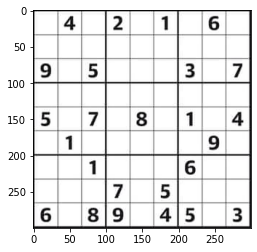

In [72]:
image = cv2.imread('sudoku.jpg')
gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(image)

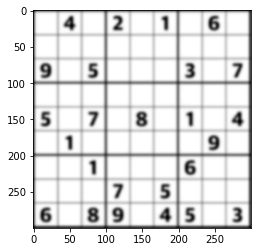

In [73]:
blur_image = cv2.GaussianBlur(gray_image,(9,9),0)
plt.imshow(blur_image, cmap='gray')

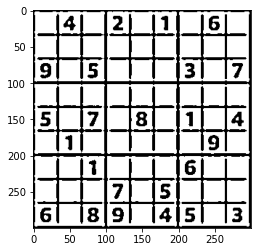

In [74]:
thresh = cv2.adaptiveThreshold(blur_image,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11 , 2)
plt.imshow(thresh, cmap='gray')

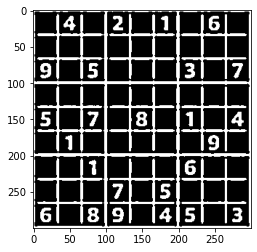

In [75]:
binary_image = cv2.bitwise_not(thresh,thresh)
plt.imshow(binary_image, cmap = 'gray')

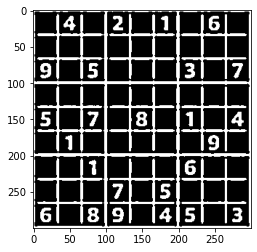

In [76]:
#kernel = np.array([[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]])
kernel = np.ones((1,1), np.uint8)
dilated_image = cv2.dilate(binary_image, kernel)
plt.imshow(dilated_image, cmap = 'gray')

In [77]:
line_image = dilated_image
temp = image
minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(line_image,1,np.pi/180,100,minLineLength,maxLineGap)
#for line in lines:
#    for x1,y1,x2,y2 in line:
        #cv2.line(temp,(x1,y1),(x2,y2),(0,255,0),1)

In [78]:
'''cv2.imshow('',temp)
cv2.waitKey()
cv2.destroyAllWindows()'''

"cv2.imshow('',temp)\ncv2.waitKey()\ncv2.destroyAllWindows()"

In [79]:
contours, hierarchy = cv2.findContours(line_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#contour_image = cv2.drawContours(image, contours, -1, (0,255,0), 1)

In [80]:
area = -1
for i in range(len(contours)):
    if cv2.contourArea(contours[i])>area:
        area = cv2.contourArea(contours[i])
        index = i
        #print('area:',area)
        #print('index:',i)
max_area = area
len(contours[index])

4

In [81]:
temp2 = image
#contour_image = cv2.drawContours(temp2,[contours[index]],0, (0,0,255),2)
'''cv2.imshow('',contour_image)
cv2.waitKey()
cv2.destroyAllWindows()'''

"cv2.imshow('',contour_image)\ncv2.waitKey()\ncv2.destroyAllWindows()"

In [82]:
cnt = contours[index]
epsilon = 0.1*cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt,epsilon,True)

In [83]:
def warp_coord(pts1):
    pts2 = [[0,0],[0,297],[297,0],[297,297]]
    ref = np.amax(pts1)//2
    pts1 = list(pts1)
    for i in range(len(pts1)):
        if pts1[i][0] < ref:
            if pts1[i][1] < ref:
                print('Top left coordinate:',pts1[i])
                pts2[i] = [0 , 0]
            elif pts1[i][1] > ref:
                print('Bottom left coordinate:',pts1[i])
                pts2[i] = [0, 297]
        elif pts1[i][0] > ref:
            if pts1[i][1] < ref:
                print('Top right coordinate:',pts1[i])
                pts2[i] = [297, 0]
            elif pts1[i][1] > ref:
                print('Bottom right coordinate:',pts1[i])
                pts2[i] = [297, 297]
    return np.float32(pts2)

In [84]:
pts1 = np.float32(approx.reshape(4,2))
pts2 = warp_coord(pts1)

Top left coordinate: [0. 0.]
Bottom left coordinate: [  0. 299.]
Bottom right coordinate: [299. 299.]
Top right coordinate: [299.   0.]


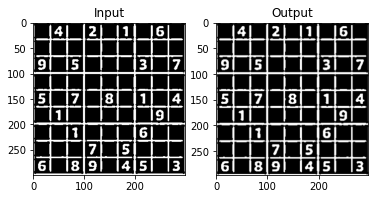

In [85]:
M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(dilated_image, M,(297,297))
plt.subplot(121),plt.imshow(binary_image,cmap='gray'),plt.title('Input')
plt.subplot(122),plt.imshow(dst,cmap='gray'),plt.title('Output')
plt.show()

In [86]:
x_size, y_size = 33, 33
number_images = []
for y in range(1,10):
    for x in range(1,10):
        number_images.append(dst[(y-1)*y_size:y*y_size,(x-1)*x_size:x*x_size])

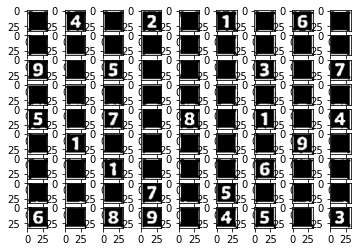

In [87]:
for i in range(81):
    plt.subplot(9,9,i+1), plt.imshow(number_images[i],cmap='gray')

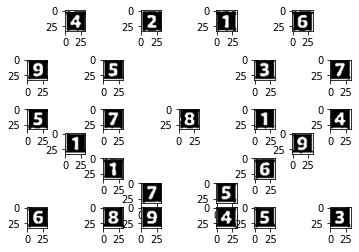

In [88]:
num_list = []
for i in range(81):
    if np.var(number_images[i][10:23,10:23]) > 10000:
        plt.subplot(9,9,i+1), plt.imshow(number_images[i],cmap='gray')
        num_list.append(i)

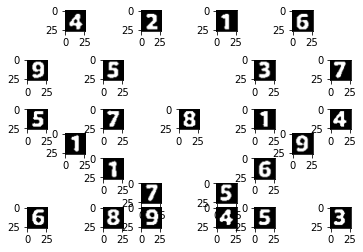

In [89]:
for i in range(81):
    if np.var(number_images[i][10:23,10:23]) > 10000:
        plt.subplot(9,9,i+1), plt.imshow(number_images[i][3:30,3:30],cmap='gray')

In [90]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [91]:
input_shape = (28,28,1)
num_classes = 10
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [92]:
model = load_model('mnist_model.h5')

In [93]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1179776   
                                                      

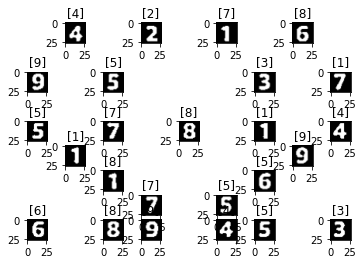

In [94]:
my_dict = {}
for index in num_list:
    buff = number_images[index][3:30,3:30]
    buff = cv2.resize(buff, (28,28))
    buff = buff.reshape(1,28,28,1)
    predict_x=model.predict(buff) 
    label = np.argmax(predict_x,axis=1)
    my_dict[index] = label[0]
    #print('Block number:',index, '\t','Predicted number:',label)
    plt.subplot(9,9,index+1), plt.imshow(number_images[index][3:30,3:30],cmap='gray')
    plt.title(label)

In [95]:
sudoku = ['0' for i in range(81)]
for key, value in my_dict.items():
    sudoku[key] = str(value)
grid1 = ''.join(sudoku)

In [96]:
grid = '003020600900305001001806400008102900700000008006708200002609500800203009005010300'

In [97]:
answer = solve(grid)
answers = list(answer.items())

In [98]:
def write_to_image(image, item):
    row = item[0][0]
    column = item[0][1]
    value = item[1]
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, value, (9+33*(int(column)-1), 25+33*(ord(row)-65)), font, 0.7, (0,255,0),2, cv2.LINE_AA)
    return image

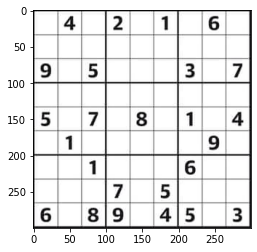

In [99]:
plt.imshow(image)
final_image = cv2.warpPerspective(image,M,(297,297))
for i in range(81):
    if grid1[i]=='0' or grid1[i]=='.':
        frame = write_to_image(final_image, answers[i] )

In [ ]:
cv2.imshow('',frame)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
plt.subplot(121),plt.imshow(image,cmap='gray'),plt.title('Input')
plt.subplot(122),plt.imshow(frame,cmap='gray'),plt.title('Output')
plt.show()

In [ ]:
N = cv2.getPerspectiveTransform(pts2,pts1)
image.shape

In [ ]:
dst2 = cv2.warpPerspective(frame, N, image.shape[1::-1])
plt.subplot(131),plt.imshow(frame,cmap='gray'),plt.title('Input')
plt.subplot(132),plt.imshow(dst2,cmap='gray'),plt.title('Output')
plt.subplot(133), plt.imshow(image, cmap='gray'),plt.title('image')
plt.show()

In [ ]:
added_image = cv2.addWeighted(image,0.5,dst2,0.5,0.5)
plt.subplot(131),plt.imshow(dst2,cmap='gray'),plt.title('Input')
plt.subplot(132),plt.imshow(image,cmap='gray'),plt.title('Output')
plt.subplot(133), plt.imshow(added_image, cmap='gray'),plt.title('image')
plt.show()

In [ ]:
cv2.imwrite('solved_sudoku.jpg',added_image)